In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive

import torch
import torch.nn as nn

%matplotlib tk

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])

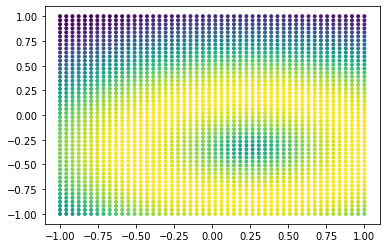

In [3]:
%matplotlib inline
plt.scatter(X1, X2, marker='.', c=Y)

## Create NN

In [4]:
torch.manual_seed(77733)

net = nn.Sequential(
        nn.utils.spectral_norm(nn.Linear(2,5)),
        nn.LeakyReLU(0.1),
        nn.utils.spectral_norm(nn.Linear(5,2))
)

In [5]:
## Spectral Normalize
for i in range(20):
    with torch.no_grad():
        yout = net(xx)+xx

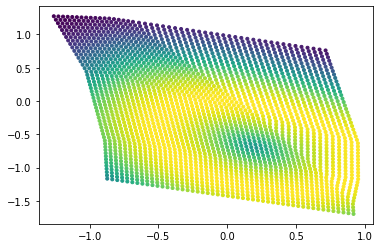

In [6]:
## this is for sure invertible.
# with torch.no_grad():
#     yout = net(xx)+xx

%matplotlib inline
y1, y2 = yout[:,0].numpy().reshape(X1.shape), yout[:,1].numpy().reshape(X1.shape)
plt.scatter(y1, y2, marker='.', c=Y)

In [7]:
nn.utils.remove_spectral_norm(net[0])
nn.utils.remove_spectral_norm(net[2])

Linear(in_features=5, out_features=2, bias=True)

## Rough

In [8]:
## this is constant 
W = torch.eye(2)
W

tensor([[1., 0.],
        [0., 1.]])

In [9]:
z1 = net[0](xx)
a1 = net[1](z1)
yout = net[2](a1) + torch.matmul(xx, W)
yout = yout.data

In [10]:
mask = (a1>0).type(torch.float32)*0.9+0.1 ##_for leaky_relu
mask

tensor([[1.0000, 1.0000, 0.1000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.1000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.1000, 1.0000, 1.0000],
        ...,
        [0.1000, 0.1000, 1.0000, 1.0000, 1.0000],
        [0.1000, 0.1000, 1.0000, 1.0000, 1.0000],
        [0.1000, 0.1000, 1.0000, 1.0000, 1.0000]])

In [11]:
#mask.reshape(-1,5,1)*net[2].weight.data.t()
net[0].weight.data.t()

tensor([[-0.0937, -0.5976,  0.0122,  0.3784, -0.2459],
        [-0.4164, -0.4164,  0.6945, -0.1008,  0.2772]])

In [12]:
net[0].weight.shape, net[2].weight.shape

(torch.Size([5, 2]), torch.Size([2, 5]))

In [13]:
We = torch.matmul(net[0].weight.data.t(), mask.reshape(-1,5,1)*net[2].weight.data.t())      

In [14]:
We

tensor([[[-0.1058, -0.2647],
         [-0.0382,  0.2028]],

        [[-0.1058, -0.2647],
         [-0.0382,  0.2028]],

        [[-0.1058, -0.2647],
         [-0.0382,  0.2028]],

        ...,

        [[ 0.0708, -0.3287],
         [-0.2144,  0.2652]],

        [[ 0.0708, -0.3287],
         [-0.2144,  0.2652]],

        [[ 0.0708, -0.3287],
         [-0.2144,  0.2652]]])

In [15]:
(We*W.reshape(1, 2, 2)).sum(dim=1, keepdim=True).shape

torch.Size([2500, 1, 2])

In [16]:
### for verification
a = torch.randn(2, 2, 3)
b = torch.randn(2, 3)

In [17]:
a

tensor([[[ 1.2614, -0.1004,  1.2408],
         [ 0.4329,  0.4466,  1.1567]],

        [[-1.1279, -0.3428, -2.5106],
         [ 0.4825,  0.3699, -0.3772]]])

In [18]:
b

tensor([[ 0.5457,  1.2279,  0.5199],
        [-0.1875,  0.3039, -0.3282]])

In [19]:
a*b.reshape(1, 2, 3)

tensor([[[ 0.6883, -0.1233,  0.6450],
         [-0.0812,  0.1357, -0.3796]],

        [[-0.6154, -0.4209, -1.3051],
         [-0.0905,  0.1124,  0.1238]]])

In [20]:
(a*b.reshape(1, 2, 3)).sum(dim=1, keepdim=True)

tensor([[[ 0.6071,  0.0124,  0.2654]],

        [[-0.7059, -0.3085, -1.1813]]])

In [21]:
### Final equation
### if any value is <=0, then there is a fold; Hence, not invertible
proj = (We*W.reshape(1, 2, 2)).sum(dim=1)
proj.shape

torch.Size([2500, 2])

In [22]:
proj

tensor([[-0.1058,  0.2028],
        [-0.1058,  0.2028],
        [-0.1058,  0.2028],
        ...,
        [ 0.0708,  0.2652],
        [ 0.0708,  0.2652],
        [ 0.0708,  0.2652]])

In [23]:
torch.count_nonzero(proj.min(dim=1)[0] > -1 )

tensor(2500)

## interactive plot

In [60]:
%matplotlib inline

ws = net[2].weight.data.t()
colors = np.array(['r', 'b'])

proj, We, yout = None, None, None
def network(w00 = ws[0,0], w01 = ws[0,1], 
            w10 = ws[1,0], w11 = ws[1,1], 
            w20 = ws[2,0], w21 = ws[2,1], 
            w30 = ws[3,0], w31 = ws[3,1], 
            w40 = ws[4,0], w41 = ws[4,1]):
    
    global proj, We, yout
    
    w2 = torch.Tensor([w00, w01, w10, w11, w20, w21, w30, w31, w40, w41]).reshape(-1,2).t()
    net[2].weight.data = w2
    
#     for i in range(20):
    with torch.no_grad():
        z1 = net[0](xx)
        a1 = net[1](z1)
        yout = net[2](a1) + torch.matmul(xx, W)
        
        mask = (a1>0).type(torch.float32)*0.9+0.1 ##_for leaky_relu
        We = torch.matmul(net[0].weight.data.t(), mask.reshape(-1,5,1)*net[2].weight.data.t())      
        proj = (We*W.reshape(1, 2, 2)).sum(dim=1)
#         proj = ((We+W)*W.reshape(1, 2, 2)).sum(dim=1)
        
        ###
        proj_ = proj.min(dim=1)[0]
        nofold = (proj_ > -1).data.numpy().astype(int)
#         nofold = (proj_ > 0).data.numpy().astype(int)
        fc = colors[nofold]    
    
    y1, y2 = yout[:,0].numpy().reshape(X1.shape), yout[:,1].numpy().reshape(X1.shape)
    plt.figure(figsize=(7*2,7*2))
    plt.scatter(y1, y2, c=fc, marker='.')
    plt.plot(y1, y2, lw=0.5)
    plt.plot(y1.T, y2.T, c='k', lw=0.5)
#     plt.show()
#     plt.savefig('ad.svg')
    print(f'Invertible: {nofold.sum()==2500}, min_proj: {proj_.min()}, {proj_.argmin()}')
    print(f'Ev: {np.linalg.svd(We[i])[1].astype(float), np.linalg.eig(We[i])[0].astype(float)}')
    print(((torch.matmul(We[i],W)+W)*W).sum(dim=1))

interactive_plot = interactive(network,
                               w00=(-3.,3.), w01=(-3.,3.),
                               w10=(-3.,3.), w11=(-3.,3.),
                               w20=(-3.,3.), w21=(-3.,3.),
                               w30=(-3.,3.), w31=(-3.,3.),
                               w40=(-3.,3.), w41=(-3.,3.)
                              )
interactive_plot ##_change w30;

interactive(children=(FloatSlider(value=-0.5607190728187561, description='w00', max=3.0, min=-3.0), FloatSlide…

In [330]:
# torch.save({'net':net.state_dict()}, "./00.2_net_state_dict.pt")

In [43]:
### analytical slope by finding the change in subsequent points

## in_x axis
dels = []
yout_ = yout.reshape(50,50, 2)
# yout_ = xx.reshape(50,50, 2)
for i in range(50-1):
    for j in range(50-1):
        ab, cd = yout_[i,j], yout_[i, j+1]
        ef = yout_[i+1, j]


        deltaX1 = cd-ab
        deltaX2 = ef-ab

#         print(ab, cd, ef)
#         print(deltaX1)
#         print(deltaX2)
#         break
#     break

        dels.append(
            (ab[0], ab[1], deltaX1[0], deltaX1[1], deltaX2[0], deltaX2[1], j, i)
        )
dels = np.array(dels)
dels

array([[-8.99342775e-01, -1.16821051e+00,  4.56476212e-03, ...,
         4.98158932e-02,  0.00000000e+00,  0.00000000e+00],
       [-8.94778013e-01, -1.18172801e+00,  4.56488132e-03, ...,
         4.98158932e-02,  1.00000000e+00,  0.00000000e+00],
       [-8.90213132e-01, -1.19524539e+00,  4.56470251e-03, ...,
         4.98160124e-02,  2.00000000e+00,  0.00000000e+00],
       ...,
       [-4.96951401e-01,  6.54963315e-01,  1.17747784e-02, ...,
         5.23615479e-02,  4.60000000e+01,  4.80000000e+01],
       [-4.85176623e-01,  6.38833225e-01,  1.17747188e-02, ...,
         5.23616076e-02,  4.70000000e+01,  4.80000000e+01],
       [-4.73401904e-01,  6.22703195e-01,  1.17747784e-02, ...,
         5.23616076e-02,  4.80000000e+01,  4.80000000e+01]])

In [44]:
dels[0] ## Y, D1, D2, ind

array([-0.89934278, -1.16821051,  0.00456476, -0.0135175 ,  0.00694537,
        0.04981589,  0.        ,  0.        ])

In [45]:
delX1 = dels[:, 2:4]
len(delX1[:,0])-(delX1[:,0] > 0).astype(int).sum(), (delX1[:,0] < 0).astype(int).sum()

(0, 0)

In [46]:
delX2 = dels[:, 4:6]
len(delX1[:,0])-(delX2[:,1] > 0).astype(int).sum()

0

In [47]:
# i = proj.min(dim=1)[0].argmin()
i = (50-16)*50+20
i

1720

In [48]:
We[i]

tensor([[-0.9376, -0.3153],
        [-0.1635,  0.3385]])

In [49]:
We[i]+W

tensor([[ 0.0624, -0.3153],
        [-0.1635,  1.3385]])

In [50]:
torch.matmul(We[i],W)

tensor([[-0.9376, -0.3153],
        [-0.1635,  0.3385]])

In [51]:
proj[i]

tensor([-0.9376,  0.3385])

In [52]:
np.linalg.svd(net[0].weight.data.t())

(array([[ 0.40397966, -0.914768  ],
        [ 0.914768  ,  0.40397966]], dtype=float32),
 array([1.       , 0.6970028], dtype=float32),
 array([[-0.4187613 , -0.6223336 ,  0.6402145 ,  0.06067547,  0.1542199 ],
        [-0.11843467,  0.5429827 ,  0.38649443, -0.55501735,  0.48344687],
        [ 0.8630152 , -0.13379113,  0.4680358 , -0.08237676, -0.10705741],
        [ 0.00824022,  0.4376266 ,  0.30238387,  0.8201958 ,  0.2103757 ],
        [ 0.2564158 , -0.32932296, -0.36090717,  0.09363326,  0.82871956]],
       dtype=float32))

In [53]:
np.linalg.svd(net[2].weight.data.t())

(array([[-0.22456329,  0.41212317, -0.11296865, -0.8407295 , -0.24523017],
        [ 0.16652173, -0.32878444,  0.15212935, -0.45786422,  0.7945995 ],
        [-0.07682329,  0.17079145,  0.9772786 ,  0.00187592, -0.09925445],
        [-0.95548344, -0.21393956, -0.02019954,  0.10217006,  0.17445482],
        [-0.05469363,  0.80443484, -0.09280744,  0.27035537,  0.51786864]],
       dtype=float32),
 array([2.2110717 , 0.76436514], dtype=float32),
 array([[ 0.9665378 ,  0.25652426],
        [-0.25652426,  0.9665378 ]], dtype=float32))

In [54]:
np.linalg.svd(We[i])

(array([[-0.9984651 , -0.05538449],
        [-0.05538449,  0.9984651 ]], dtype=float32),
 array([0.990512  , 0.37247244], dtype=float32),
 array([[ 0.95427006,  0.29894584],
        [-0.29894584,  0.95427006]], dtype=float32))

In [55]:
np.linalg.eig(We[i])

(array([-0.9768039 ,  0.37769958], dtype=float32),
 array([[-0.9923597 ,  0.23314178],
        [-0.12337821, -0.97244275]], dtype=float32))

In [56]:
We[i]

tensor([[-0.9376, -0.3153],
        [-0.1635,  0.3385]])

In [57]:
np.linalg.svd(We[i]*W.data.numpy())

(array([[1., 0.],
        [0., 1.]], dtype=float32),
 array([0.93759817, 0.33849385], dtype=float32),
 array([[-1., -0.],
        [ 0.,  1.]], dtype=float32))

In [58]:
torch.norm(We[i], dim=0, keepdim=True)

tensor([[0.9518, 0.4626]])

tensor(5000.)


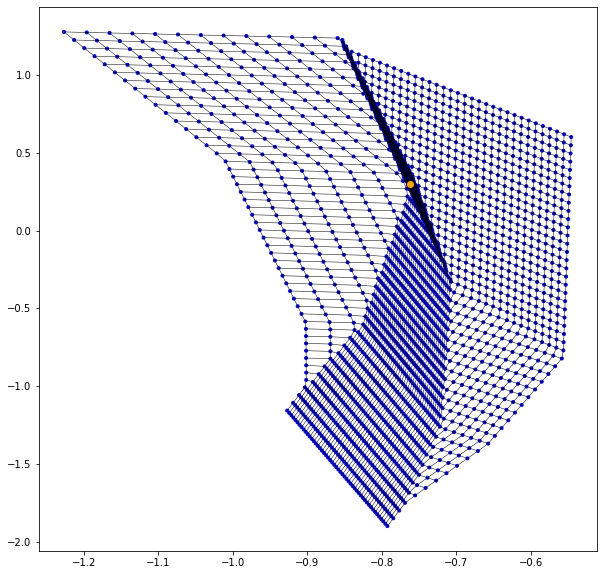

Invertible: True, min_proj: -0.9822019934654236, 1333


In [344]:
with torch.no_grad():
    z1 = net[0](xx)
    a1 = net[1](z1)
    _yout = net[2](a1) + torch.matmul(xx, W)
    print((_yout==yout).type(torch.float32).sum())
    

    mask = (a1>0).type(torch.float32)*0.9+0.1 ##_for leaky_relu
    We = torch.matmul(net[0].weight.data.t(), mask.reshape(-1,5,1)*net[2].weight.data.t())      
    proj = (We*W.reshape(1, 2, 2)).sum(dim=2)
#     proj = ((We+W)*W.reshape(1, 2, 2)).sum(dim=1)

    ###
    proj_ = proj.min(dim=1)[0]
    nofold = (proj_ > -1).data.numpy().astype(int)
#     nofold = (proj_ > 0).data.numpy().astype(int)
    fc = colors[nofold]    
    
y1, y2 = yout[:,0].numpy().reshape(X1.shape), yout[:,1].numpy().reshape(X1.shape)
plt.figure(figsize=(10,10))
plt.scatter(y1, y2, c=fc, marker='.')
plt.plot(y1, y2, c='k', lw=0.5)
plt.plot(y1.T, y2.T, c='k', lw=0.5)

plt.scatter([yout[:,0].numpy()[i]], [yout[:,1].numpy()[i]], c='orange', zorder=10)

plt.show()
print(f'Invertible: {nofold.sum()==2500}, min_proj: {proj_.min()}, {proj_.argmin()}')

In [345]:
### check the projection on input dimension

In [346]:
with torch.no_grad():
    z1 = net[0](xx)
    a1 = net[1](z1)
    yout = net[2](a1) + torch.matmul(xx, W)

    mask = (a1>0).type(torch.float32)*0.9+0.1 ##_for leaky_relu
    We = torch.matmul(net[0].weight.data.t()*mask.reshape(-1,1,5), net[2].weight.data.t())      
    proj = (We*W.reshape(1, 2, 2)).sum(dim=1)
#         proj = ((We+W)*W.reshape(1, 2, 2)).sum(dim=1)

    ###
    proj_ = proj.min(dim=1)[0]
    nofold = (proj_ > -1).data.numpy().astype(int)
#         nofold = (proj_ > 0).data.numpy().astype(int)
    fc = colors[nofold]

In [347]:
proj[i]

tensor([-0.9822,  0.3476])

In [348]:
We[i]

tensor([[-0.9822, -0.3534],
        [-0.1399,  0.3476]])

## eigenvector and projection

In [349]:
U,D,V = np.linalg.svd(We[i])
U,D,V

(array([[-0.9998817, -0.015383 ],
        [-0.015383 ,  0.9998817]], dtype=float32),
 array([1.0439506 , 0.37442964], dtype=float32),
 array([[ 0.94280183,  0.33335376],
        [-0.33335376,  0.94280183]], dtype=float32))

In [350]:
np.matmul(np.matmul(U,np.diag(D)), V)

array([[-0.982202  , -0.35339406],
       [-0.1399433 ,  0.34761783]], dtype=float32)

In [351]:
U

array([[-0.9998817, -0.015383 ],
       [-0.015383 ,  0.9998817]], dtype=float32)

In [352]:
np.linalg.svd(W)

(array([[1., 0.],
        [0., 1.]], dtype=float32),
 array([1., 1.], dtype=float32),
 array([[1., 0.],
        [0., 1.]], dtype=float32))